## Data Exploration

At first, we used heatmaps and histograms to visualize our dataset. By visualization we can get a sense of the distribution of our data, and choose a proper model to capture information in our dataset.

In [23]:
import pandas as pd
import numpy as np
import scipy
import pymc
from scipy import ndimage
from matplotlib import pyplot as plt
% matplotlib inline
from collections import Counter
import scipy
import datetime as dt
import matplotlib.dates as mdates
import random

import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

Load dataset and show the structure of our dataset

In [2]:
data = pd.read_csv('Crimes_-_2001_to_present.csv')
data.head()

/Users/tianlan/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


ID Case Number                    Date               Block  IUCR  \
0  10014730    HY204464  03/30/2015 11:55:00 PM  039XX N SAWYER AVE  502P   
1  10014752    HY204478  03/30/2015 11:55:00 PM  023XX N PULASKI RD  4625   
2  10014745    HY204475  03/30/2015 11:50:00 PM   082XX S LAFLIN ST  0486   
3  10016190    HY205647  03/30/2015 11:49:00 PM  049XX W MELROSE ST  1320   
4  10014731    HY204470  03/30/2015 11:40:00 PM     010XX E 45TH ST  1320   

      Primary Type               Description Location Description Arrest  \
0    OTHER OFFENSE  FALSE/STOLEN/ALTERED TRP               STREET  False   
1    OTHER OFFENSE          PAROLE VIOLATION               STREET   True   
2          BATTERY   DOMESTIC BATTERY SIMPLE            APARTMENT  False   
3  CRIMINAL DAMAGE                TO VEHICLE               STREET  False   
4  CRIMINAL DAMAGE                TO VEHICLE               STREET  False   

  Domestic              ...                Ward  Community Area  FBI Code  \
0    False              ...                  33              16        26   
1    False              ...                  30              22        26   
2    False              ...                  21              71       08B   
3    False              ...                  30              15        14   
4    False              ...                   4              39        14   

  X Coordinate Y Coordinate  Year              Updated On   Latitude  \
0      1153985      1925832  2015  04/06/2015 12:56:12 PM  41.952317   
1      1149360      1915589  2015  04/06/2015 12:56:12 PM  41.924300   
2      1167816      1849819  2015  04/06/2015 12:56:12 PM  41.743443   
3      1143008      1921117  2015  04/06/2015 12:56:12 PM  41.939591   
4      1183876      1875345  2015  04/06/2015 12:56:12 PM  41.813129   

   Longitude                       Location  
0 -87.709345  (41.952316792, -87.709344665)  
1 -87.726613  (41.924300288, -87.726612888)  
2 -87.660690  (41.743442598, -87.660690316)  
3 -87.749815    (41.93959062, -87.74981479)  
4 -87.601049  (41.813128694, -87.601049464)  

[5 rows x 22 columns]

Here is all information we can get for each crime event

In [3]:
data.columns

Index([u'ID', u'Case Number', u'Date', u'Block', u'IUCR', u'Primary Type', u'Description', u'Location Description', u'Arrest', u'Domestic', u'Beat', u'District', u'Ward', u'Community Area', u'FBI Code', u'X Coordinate', u'Y Coordinate', u'Year', u'Updated On', u'Latitude', u'Longitude', u'Location'], dtype='object')

Here's a list of all crime types.

In [4]:
set(data['Primary Type'])

{'ARSON',
 'ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'CRIM SEXUAL ASSAULT',
 'CRIMINAL DAMAGE',
 'CRIMINAL TRESPASS',
 'DECEPTIVE PRACTICE',
 'DOMESTIC VIOLENCE',
 'GAMBLING',
 'HOMICIDE',
 'HUMAN TRAFFICKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'INTIMIDATION',
 'KIDNAPPING',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'NON - CRIMINAL',
 'NON-CRIMINAL',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'OBSCENITY',
 'OFFENSE INVOLVING CHILDREN',
 'OTHER NARCOTIC VIOLATION',
 'OTHER OFFENSE',
 'PROSTITUTION',
 'PUBLIC INDECENCY',
 'PUBLIC PEACE VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'SEX OFFENSE',
 'STALKING',
 'THEFT',
 'WEAPONS VIOLATION'}

** The Count of each crime type.**

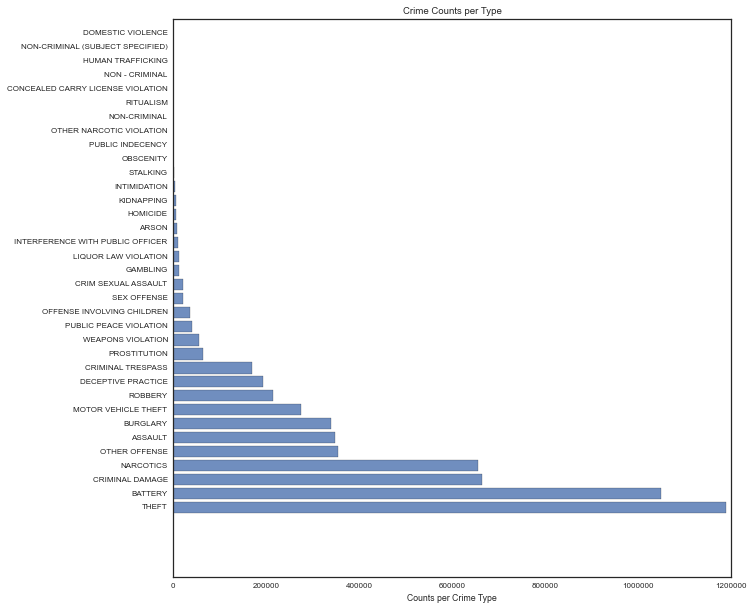

In [19]:
crime_counts = Counter(data['Primary Type'])
crime_type_Counter = crime_counts.most_common()

crime_type = []
crime_count = []
for i,crime in enumerate(crime_type_Counter):
    crime_type.append(crime_type_Counter[i][0])
    crime_count.append(crime_type_Counter[i][1])
y_pos = np.arange(len(crime_type))

plt.figure(figsize=(10,10))
plt.barh(y_pos, crime_count, align='center', alpha=0.8)
plt.yticks(y_pos, crime_type)
plt.xlabel('Counts per Crime Type')
plt.title('Crime Counts per Type')

plt.show()

**Crime Counts per Year**

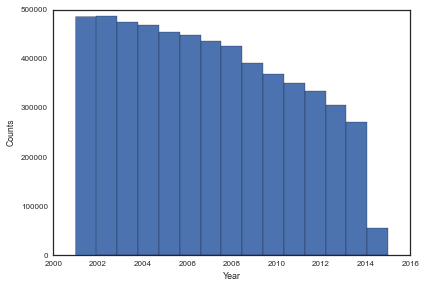

In [20]:
plt.figure()
plt.hist(data['Year'],bins=15)
plt.xlabel('Year')
plt.ylabel('Counts')

**Heatmap for All Crimes**

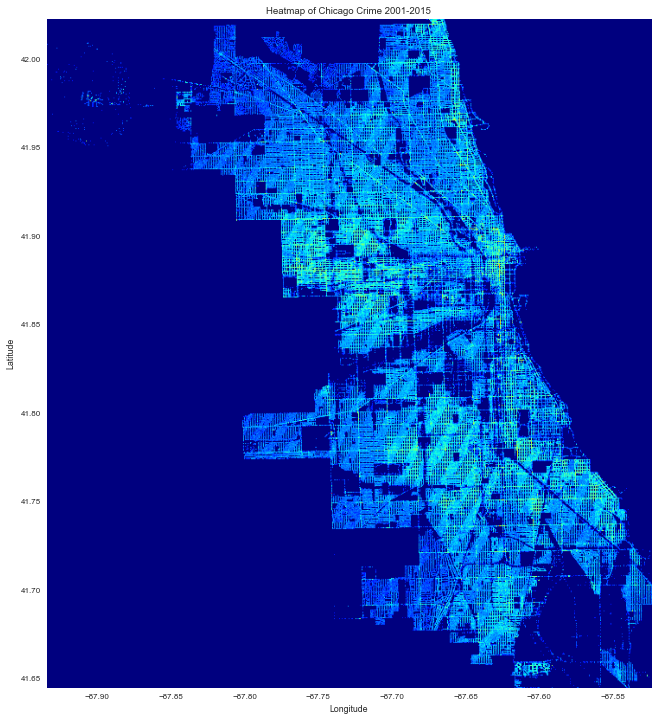

In [15]:
fig = plt.figure(figsize=(12,12))

heatmap, xedges, yedges = np.histogram2d(data.Longitude.dropna(), data.Latitude.dropna(), bins=700)
rotated = ndimage.rotate(heatmap,90,reshape=True)
rotated = np.around(rotated,5)
plt.imshow(rotated**0.2,cmap='jet', aspect=1.2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Chicago Crime 2001-2015')
plt.grid(False)
plt.show()

** The Distribution of Crimes**

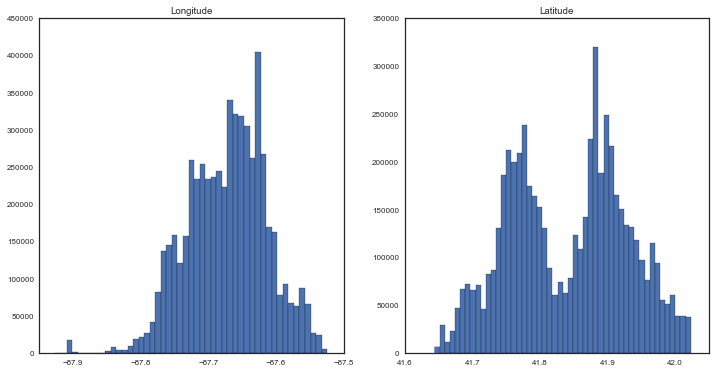

In [21]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(data.Longitude.dropna(),bins=50)
plt.title('Longitude')

plt.subplot(1,2,2)
plt.hist(data.Latitude.dropna(),bins=50)
plt.title('Latitude')

plt.show()

As our dataset is very large, we decide to look at the distribution of narcotics.

In [38]:
# Subset only narcotics crimes
data_sub = data[data['Primary Type']=='NARCOTICS']

# Extract longitude (X-coordinate) and latitude (Y-coordinate)
locations = data_sub[['Longitude', 'Latitude']].dropna()

X = list(locations['Longitude'])
Y = list(locations['Latitude'])

**The heatmap for the Narcotics samples**

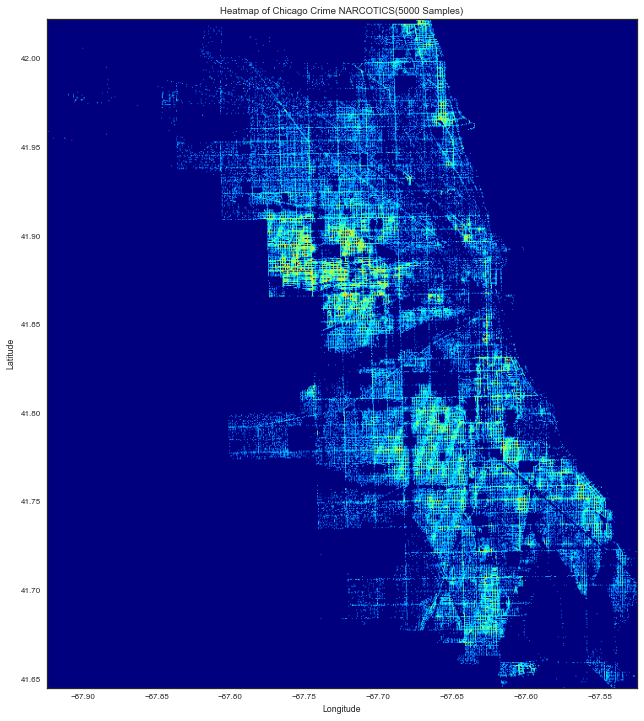

In [39]:
fig = plt.figure(figsize=(12,12))
heatmap, xedges, yedges = np.histogram2d(X, Y, bins=700)
rotated = ndimage.rotate(heatmap,90,reshape=True)
rotated = np.around(rotated,5)
plt.imshow(rotated**0.2,cmap='jet', aspect=1.2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Chicago Crime NARCOTICS(5000 Samples)')
plt.show()

** The Distribution of Narcotics samples**

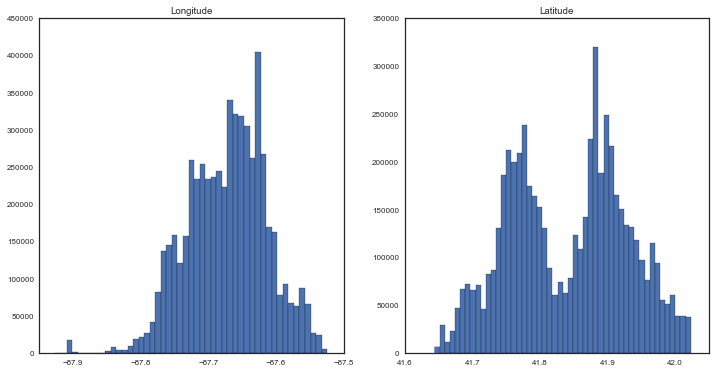

In [40]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(data.Longitude.dropna(),bins=50)
plt.title('Longitude')

plt.subplot(1,2,2)
plt.hist(data.Latitude.dropna(),bins=50)
plt.title('Latitude')

plt.show()

** Subsampling 5000 samples **

In [27]:
# Subset only narcotics crimes
data_sub = data[data['Primary Type']=='NARCOTICS']

# Extract longitude (X-coordinate) and latitude (Y-coordinate)
locations = data_sub[['Longitude', 'Latitude']].dropna()

data_sub_2013 = data_sub[data_sub['Year'] == 2014]
locations_2013 = data_sub_2013[['Longitude', 'Latitude']].dropna()

X = list(locations_2013['Longitude'])
Y = list(locations_2013['Latitude'])

In [28]:
XX = random.sample(X, 5000)
YY = [1]*len(XX)
for i in xrange(len(XX)):
    idx = X.index(XX[i])
    YY[i] = Y[idx]
X = XX
Y = YY

In [41]:
new_data = pd.read_pickle('Data_Subset_5000_Year2013')
X = list(new_data[0])
Y = list(new_data[1])

**The heatmap for the selected samples**

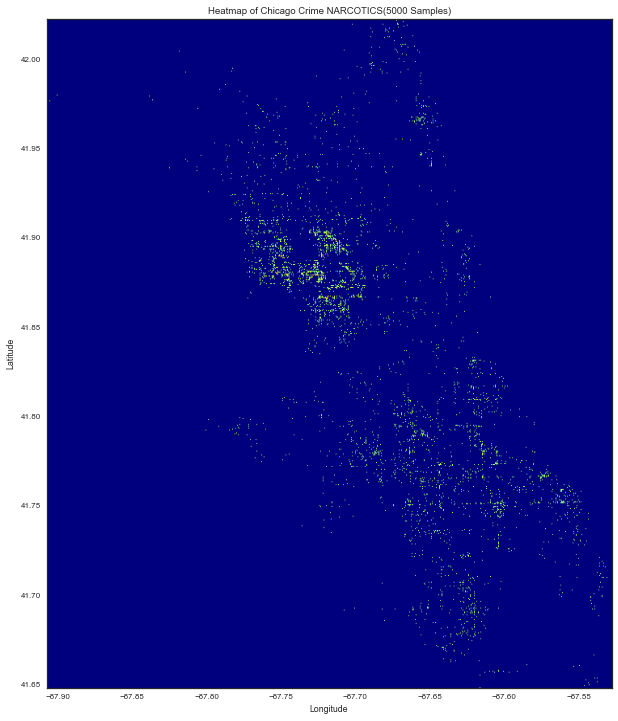

In [42]:
fig = plt.figure(figsize=(12,12))
heatmap, xedges, yedges = np.histogram2d(X, Y, bins=700)
rotated = ndimage.rotate(heatmap,90,reshape=True)
rotated = np.around(rotated,5)
plt.imshow(rotated**0.2,cmap='jet', aspect=1.2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Chicago Crime NARCOTICS(5000 Samples)')
plt.show()

** The Distribution of Selected Samples **

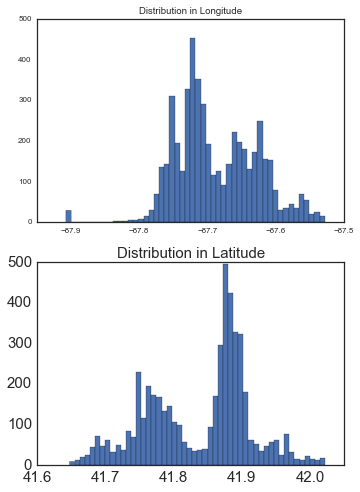

In [43]:
fig = plt.figure(figsize=(10,20))
plt.subplot(2,1,1)
# Plot the multi-modal distribution we want to sample from 
plt.hist(list(X),normed=False,bins=50,label='True Long')
plt.title('Distribution in Longitude')

plt.subplot(2,1,2)
# Plot the multi-modal distribution we want to sample from 
plt.hist(list(Y),normed=False,bins=50,label='True Lat')
plt.title('Distribution in Latitude')

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
    
plt.grid(b=False)

fig = plt.gcf()
fig.set_size_inches(5.5,8)

plt.show()

** Plot the Heatmap and distribution of crimes for all crime types  **

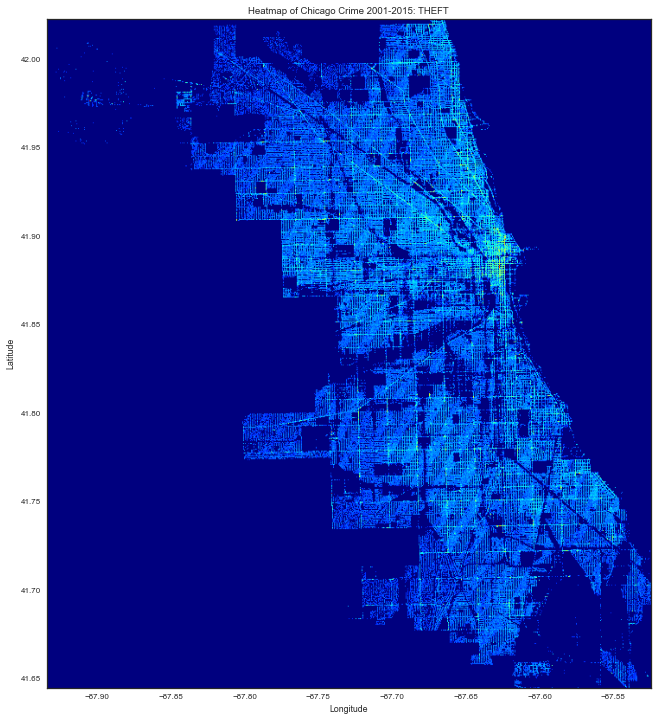

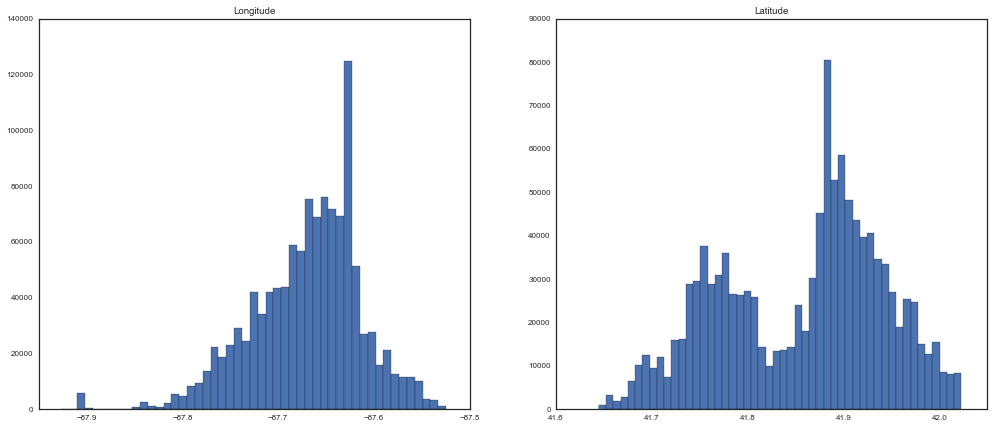

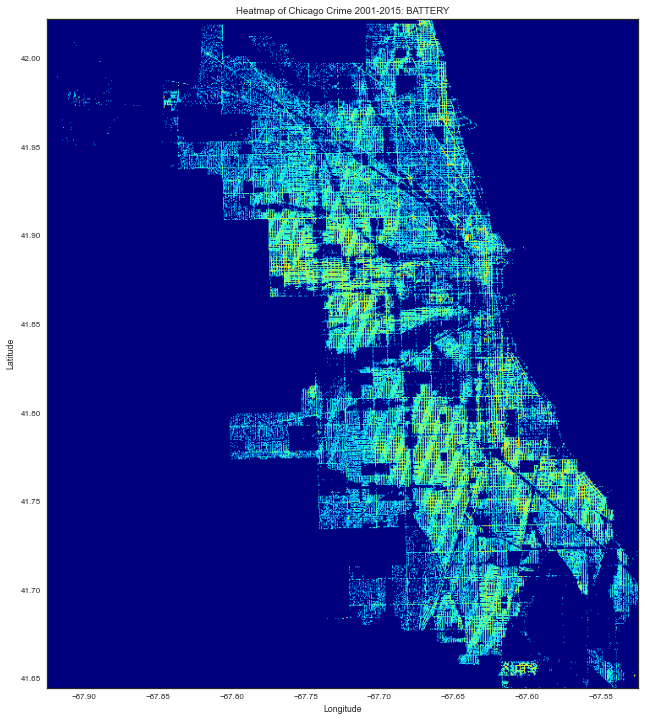

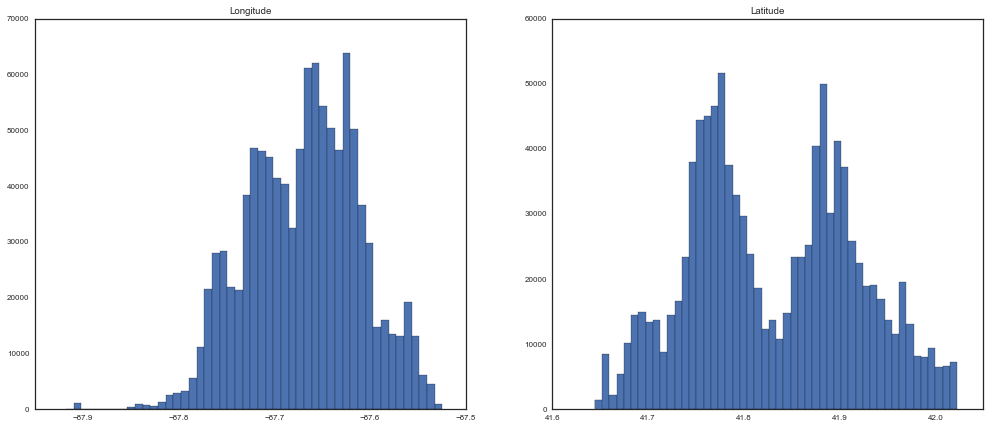

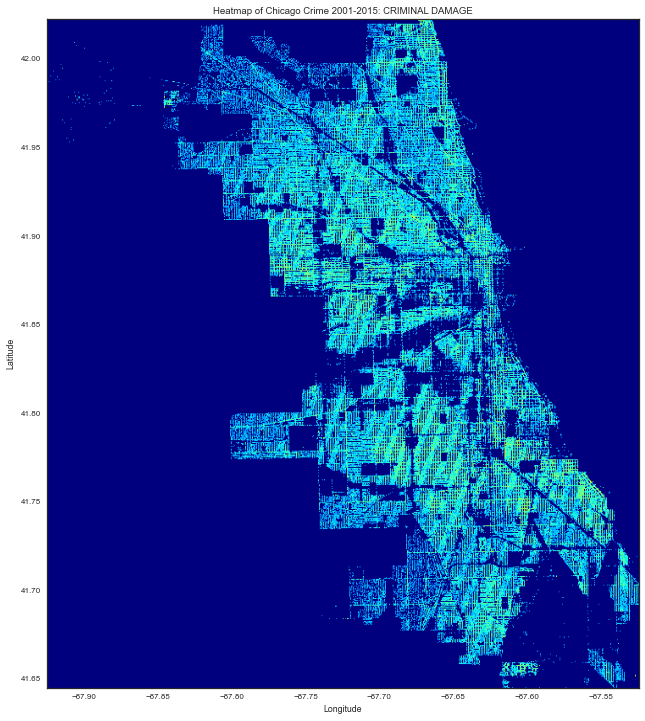

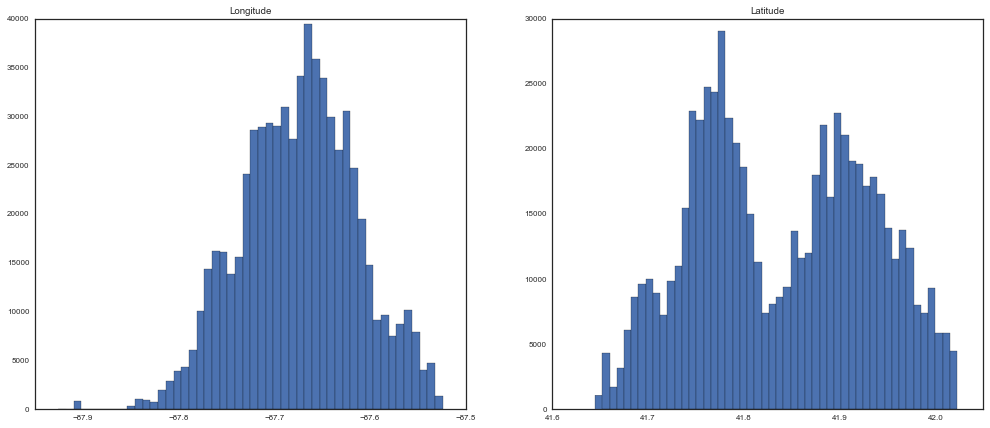

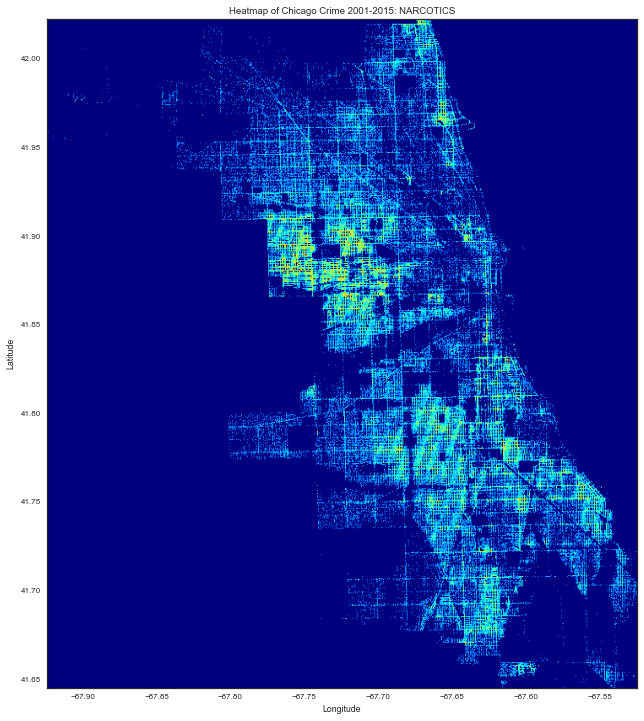

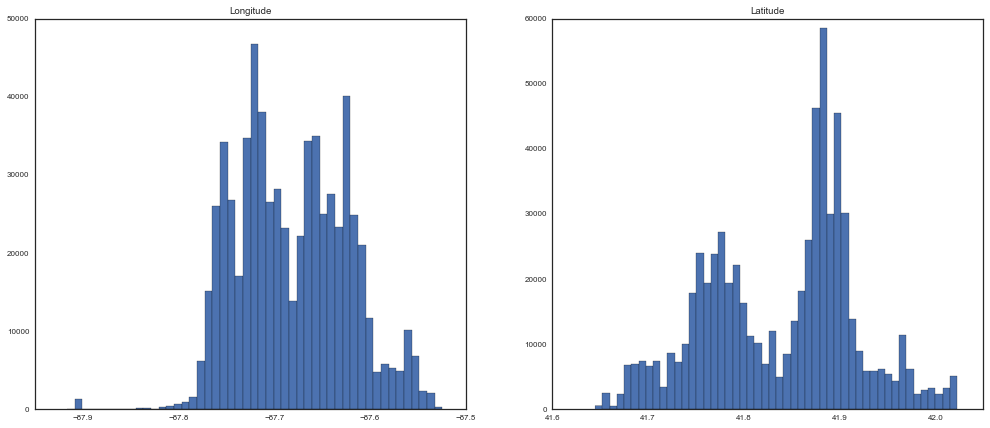

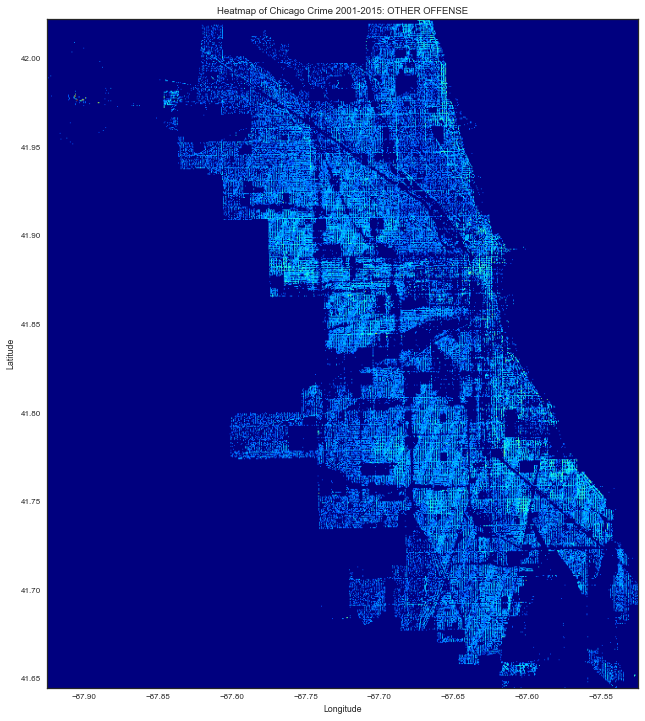

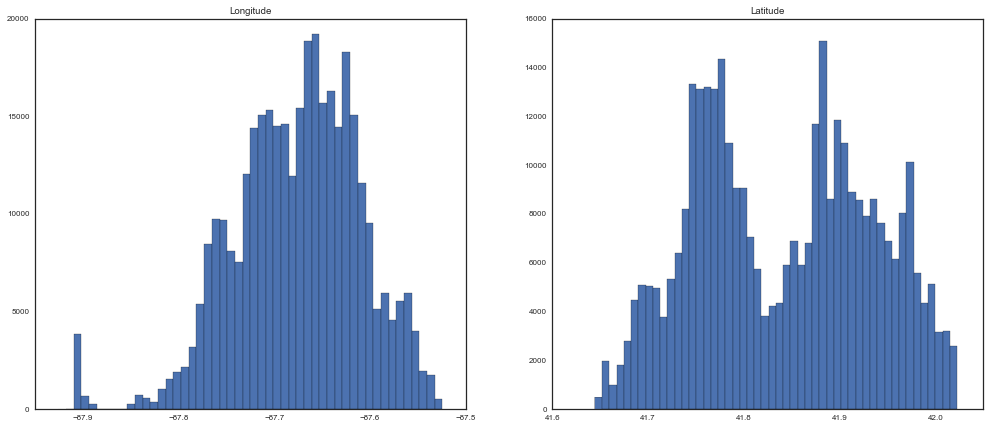

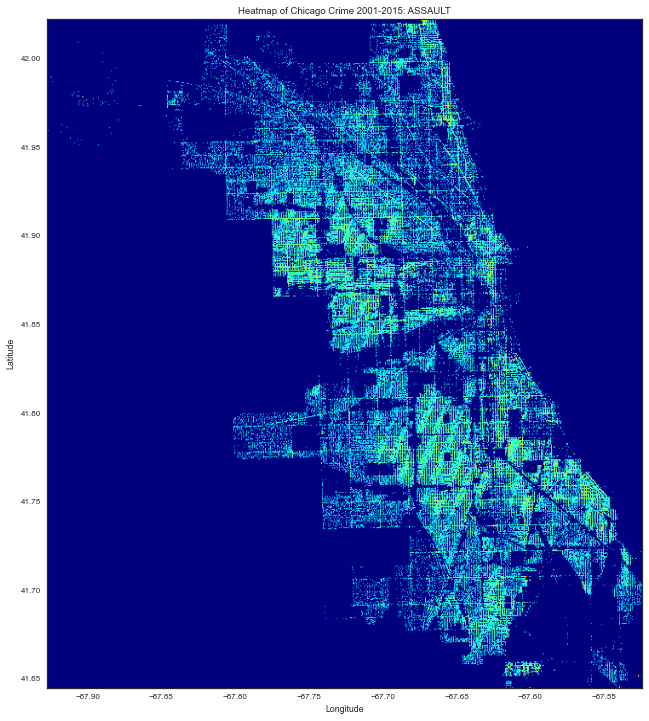

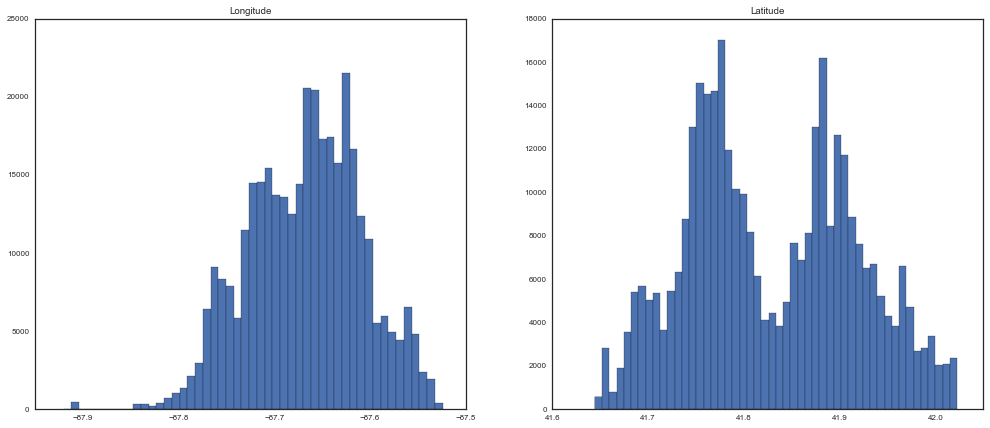

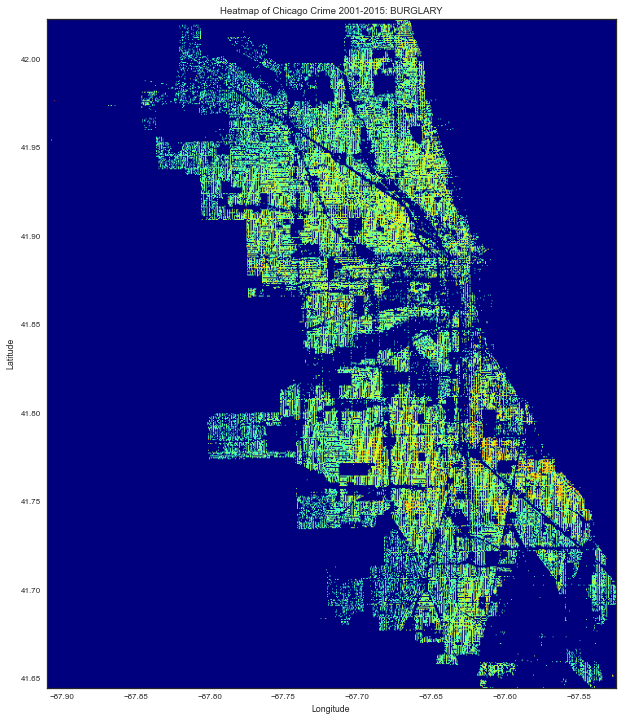

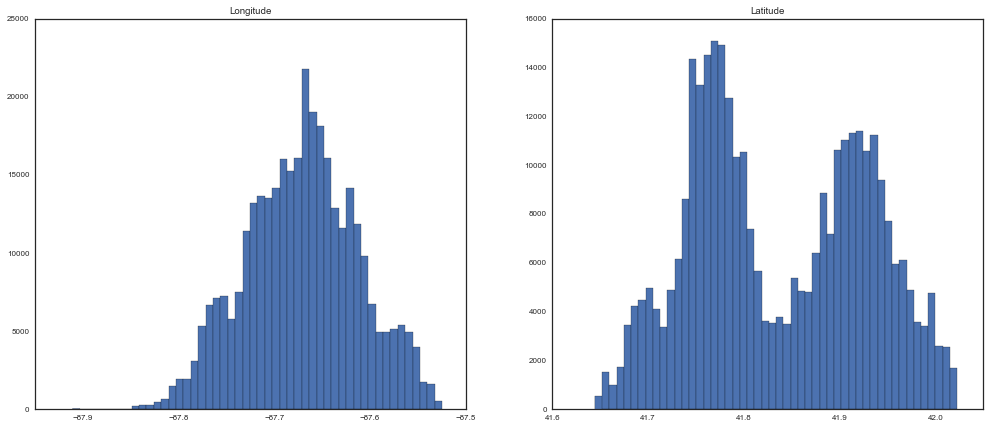

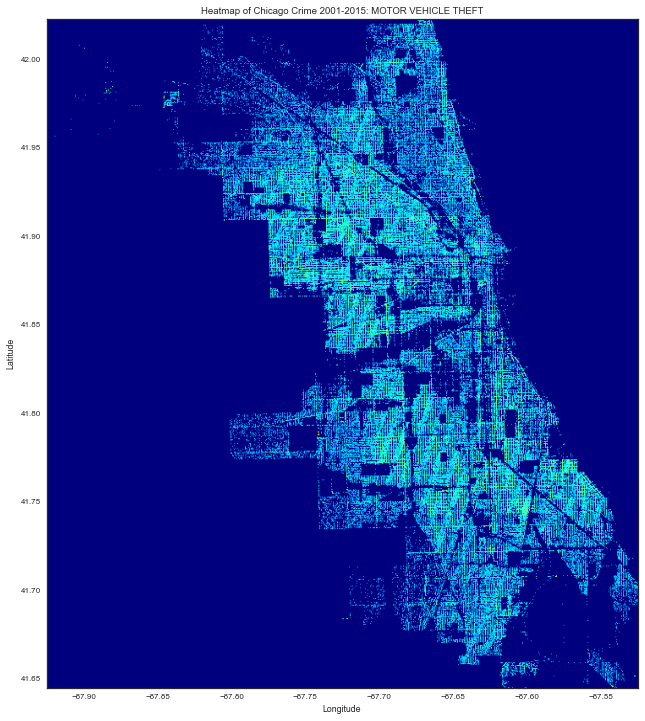

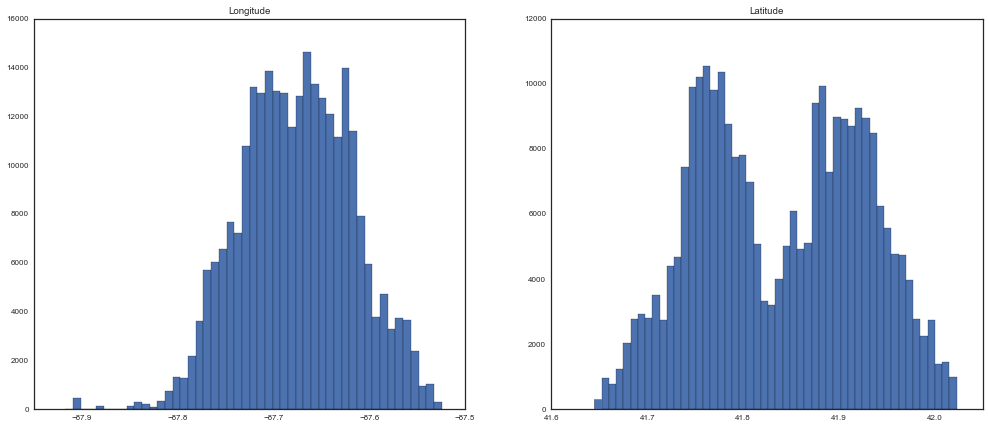

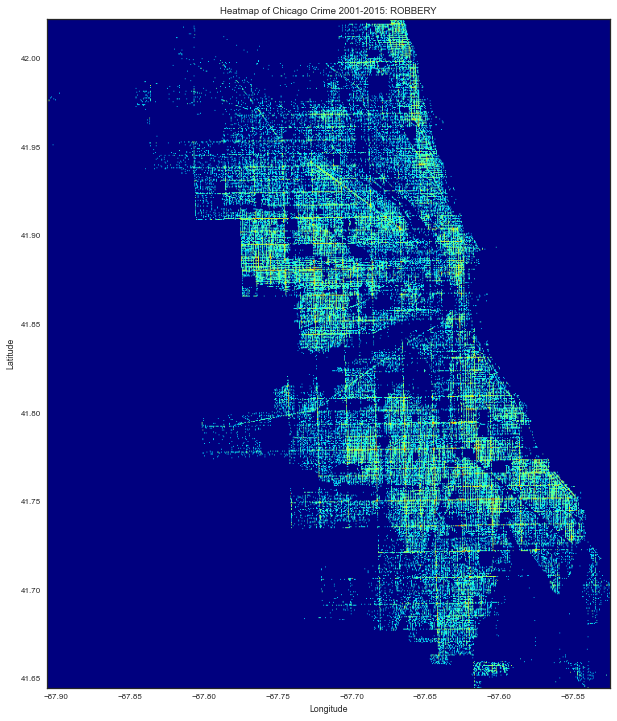

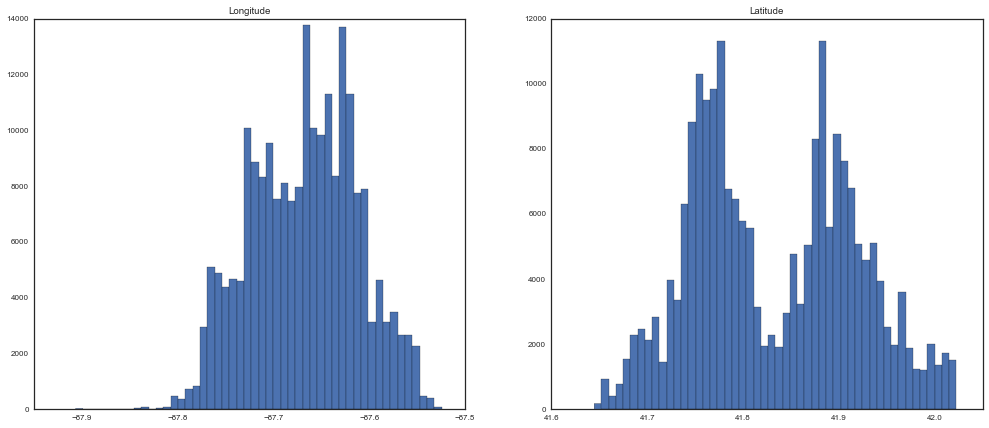

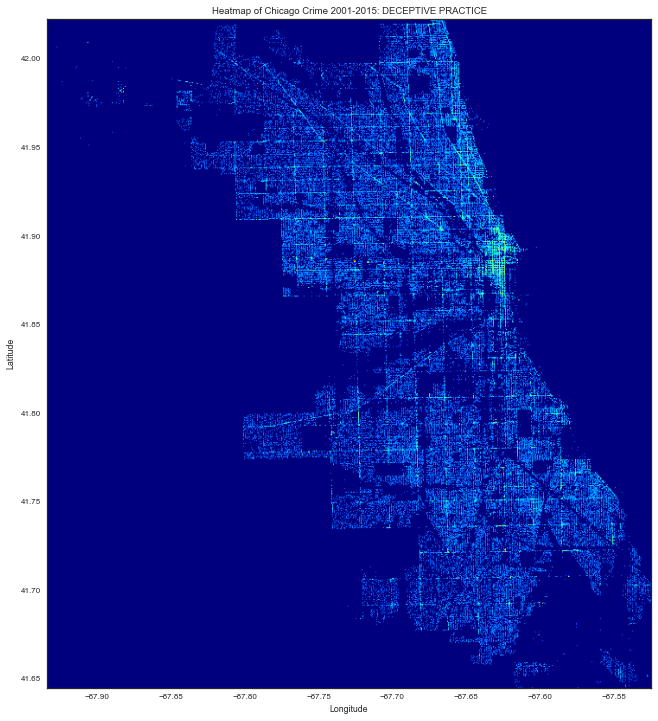

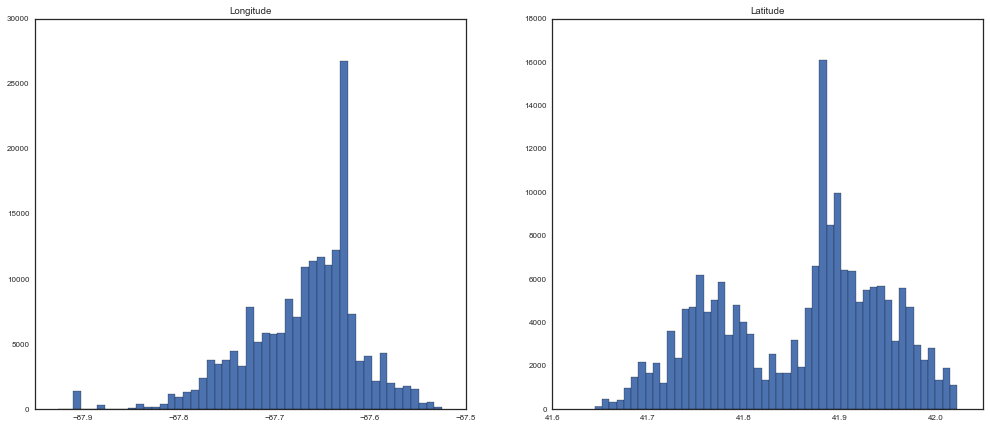

In [45]:
for i,crime in enumerate(crime_type[0:10]):
    data_sub = data[data['Primary Type']==crime]
    locations = data_sub[['Longitude', 'Latitude']].dropna()
    
    
    
    fig = plt.figure(figsize=(12,12))
    # fig = plt.figure()

    heatmap, xedges, yedges = np.histogram2d(locations['Longitude'], locations['Latitude'], bins=700)
    # plt.imshow(heatmap**0.4, aspect=2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # plt.imshow(heatmap**0.1, cmap='terrain', aspect=2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # plt.imshow(heatmap**0.4, aspect=2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    rotated = ndimage.rotate(heatmap,90,reshape=True)
    rotated = np.around(rotated,5)
    plt.imshow(rotated**0.2,cmap='jet', aspect=1.2,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    # plt.xlim(73.9,74)
    # plt.ylim(-40.75,-40.65)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Heatmap of Chicago Crime 2001-2015: '+str(crime))
    plt.show()
    
    
    plt.figure(figsize=(17,7))
    plt.subplot(1,2,1)
    plt.hist(list(locations['Longitude']),bins=50)
    plt.title('Longitude')

    plt.subplot(1,2,2)
    plt.hist(list(locations['Latitude']),bins=50)
    plt.title('Latitude')

    plt.show()